In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings 

warnings.filterwarnings('ignore')

from sklearn.svm import SVC,LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.externals import joblib

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

from scipy.stats import skew, kurtosis

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

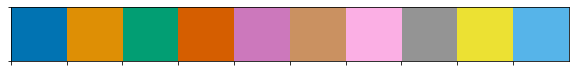

In [3]:
from code.models import cv_check, cv_bp, model_score, mod_eval, model_training
from code.preprocessing import preprocess, prop_check, make_index, categorize, add_feat

### import data

In [4]:
cc_dataset = pd.read_csv('CC_Approval_dataset.csv')
cc_dataset.replace('?', np.NaN, inplace = True)
cc_dataset["Age"] = pd.to_numeric(cc_dataset["Age"])


In [5]:
print(cc_dataset)

    Male    Age    Debt Married BankCustomer EducationLevel Ethnicity  \
0      b  30.83   0.000       u            g              w         v   
1      a  58.67   4.460       u            g              q         h   
2      a  24.50   0.500       u            g              q         h   
3      b  27.83   1.540       u            g              w         v   
4      b  20.17   5.625       u            g              w         v   
5      b  32.08   4.000       u            g              m         v   
6      b  33.17   1.040       u            g              r         h   
7      a  22.92  11.585       u            g             cc         v   
8      b  54.42   0.500       y            p              k         h   
9      b  42.50   4.915       y            p              w         v   
10     b  22.08   0.830       u            g              c         h   
11     b  29.92   1.835       u            g              c         h   
12     a  38.25   6.000       u            g       

In [6]:
cc_dataset.isnull().sum()

Male              12
Age               12
Debt               0
Married            6
BankCustomer       6
EducationLevel     9
Ethnicity          9
YearsEmployed      0
PriorDefault       0
Employed           0
CreditScore        0
DriversLicense     0
Citizen            0
ZipCode           13
Income             0
Approved           0
dtype: int64

In [7]:
cc_dataset = cc_dataset.fillna(cc_dataset.mean())

In [8]:
print(cc_dataset)

    Male    Age    Debt Married BankCustomer EducationLevel Ethnicity  \
0      b  30.83   0.000       u            g              w         v   
1      a  58.67   4.460       u            g              q         h   
2      a  24.50   0.500       u            g              q         h   
3      b  27.83   1.540       u            g              w         v   
4      b  20.17   5.625       u            g              w         v   
5      b  32.08   4.000       u            g              m         v   
6      b  33.17   1.040       u            g              r         h   
7      a  22.92  11.585       u            g             cc         v   
8      b  54.42   0.500       y            p              k         h   
9      b  42.50   4.915       y            p              w         v   
10     b  22.08   0.830       u            g              c         h   
11     b  29.92   1.835       u            g              c         h   
12     a  38.25   6.000       u            g       

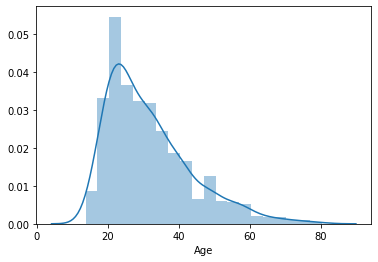

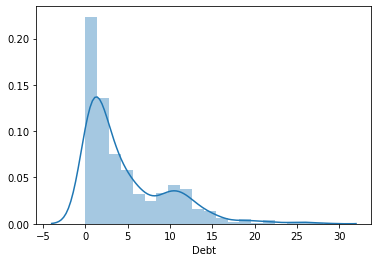

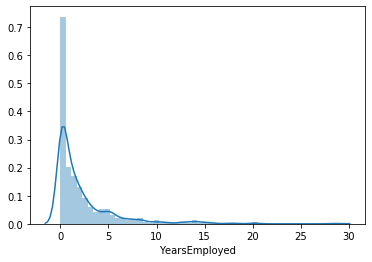

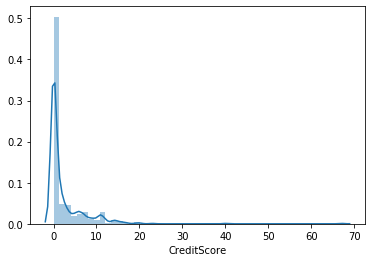

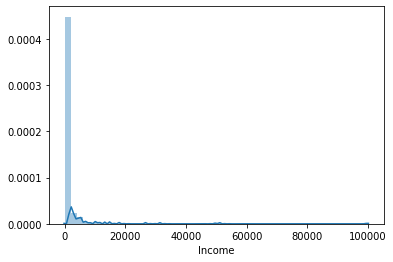

In [9]:
def plotDistPlot(col):
    """Flexibly plot a univariate distribution of observation"""
    sns.distplot(col)
    plt.show()
plotDistPlot(cc_dataset['Age'])
plotDistPlot(cc_dataset['Debt'])
plotDistPlot(cc_dataset['YearsEmployed'])
plotDistPlot(cc_dataset['CreditScore'])
plotDistPlot(cc_dataset['Income'])

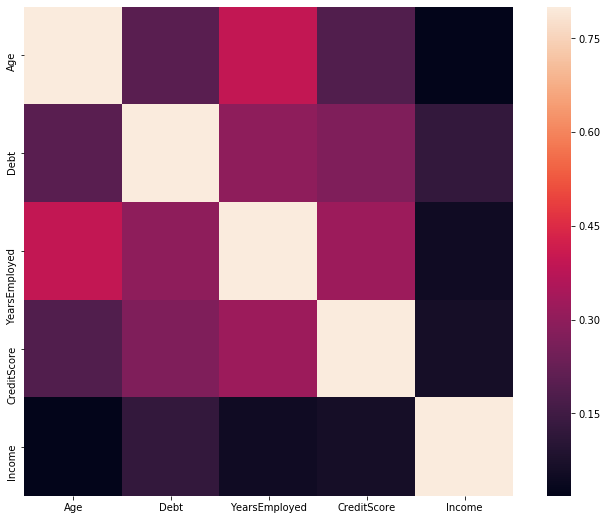

In [10]:
corrmat = cc_dataset.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

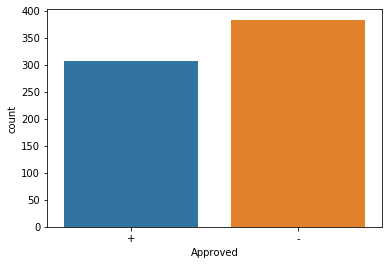

In [11]:
sns.countplot(data = cc_dataset, x = 'Approved')

In [12]:
def imputeWithMode(df):
    """ 
    Going through each columns and checking the type is object
    if it is object, impute it with most frequent value
    """
    for col in df:
        if df[col].dtypes == 'object':
            df[col] = df[col].fillna(df[col].mode().iloc[0])
imputeWithMode(cc_dataset)

In [13]:
cc_dataset.isnull().sum()

Male              0
Age               0
Debt              0
Married           0
BankCustomer      0
EducationLevel    0
Ethnicity         0
YearsEmployed     0
PriorDefault      0
Employed          0
CreditScore       0
DriversLicense    0
Citizen           0
ZipCode           0
Income            0
Approved          0
dtype: int64

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# # Looping for each object type column
#Using label encoder to convert into numeric types
for col in cc_dataset:
    if cc_dataset[col].dtypes=='object':
        cc_dataset[col]=le.fit_transform(cc_dataset[col])

In [15]:
cc_dataset

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,0,12,7,1.250,1,1,1,0,0,42,0,0
1,0,58.67,4.460,1,0,10,3,3.040,1,1,6,0,0,118,560,0
2,0,24.50,0.500,1,0,10,3,1.500,1,0,0,0,0,74,824,0
3,1,27.83,1.540,1,0,12,7,3.750,1,1,5,1,0,1,3,0
4,1,20.17,5.625,1,0,12,7,1.710,1,0,0,0,2,8,0,0
5,1,32.08,4.000,1,0,9,7,2.500,1,0,0,1,0,96,0,0
6,1,33.17,1.040,1,0,11,3,6.500,1,0,0,1,0,25,31285,0
7,0,22.92,11.585,1,0,2,7,0.040,1,0,0,0,0,159,1349,0
8,1,54.42,0.500,2,2,8,3,3.960,1,0,0,0,0,34,314,0
9,1,42.50,4.915,2,2,12,7,3.165,1,0,0,1,0,140,1442,0


In [16]:
data_set = cc_dataset

### Classifiers optimization

- In our case: binary classification, the "cross_val_score" function uses StratifiedKFold cross validation to reduce the bias effect in imbalanced data.
- it is a good approach for the cases the target column distribution is biased

Currently fitting: RandomForestClassifier
Currently fitting: SVC
Currently fitting: LogisticRegression
Currently fitting: GaussianNB
Currently fitting: DummyClassifier


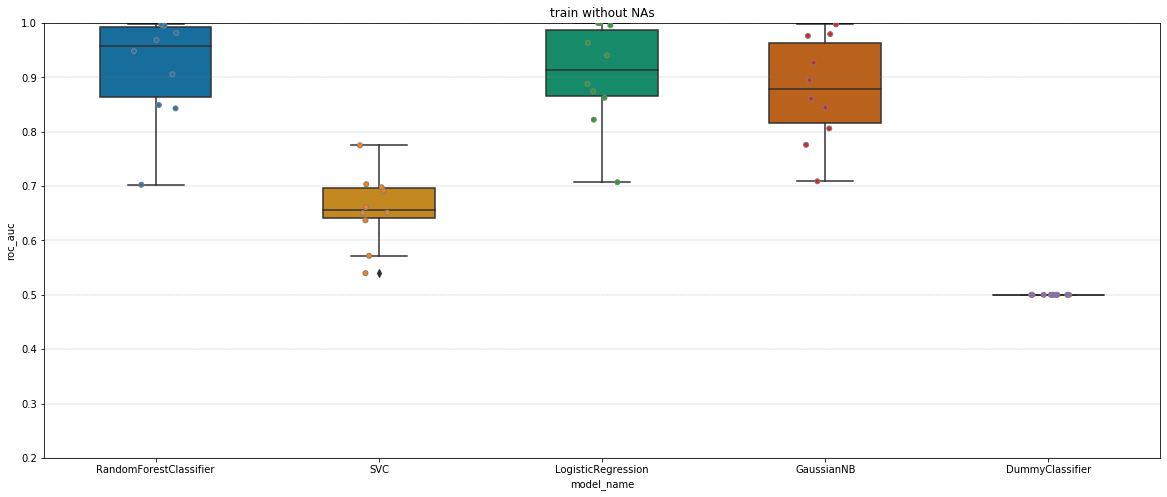

In [17]:
f, axes = plt.subplots(1,1,figsize= (20,8),squeeze=False, sharey=True)
cv_bp(cv_check(cc_dataset.drop(['Approved'],axis=1),
               cc_dataset.Approved,10), '{} without NAs'.format('train'),axes[0,0])

In [18]:
def model_score(train, model, grid_values, scorers_list):
    X_train = train.drop(columns=['Approved'])
    y_train = train['Approved']
    
    clf_dict = {}
    
    for i, scorer in enumerate(scorers_list):
        clf_eval = GridSearchCV(model, param_grid=grid_values, scoring=scorer, cv=5, iid=False)
        clf_eval.fit(X_train,y_train)
        print('Grid best parameters for {0}: {1} scoring: {2}'
              .format(scorer, clf_eval.best_params_, round(clf_eval.best_score_,3)))
        clf_dict[scorer] = clf_eval
    return clf_dict

- using grid search cross validation we scanned to find the optimal values for each model variables
- the values chosen after several runs to get the optimum variables within the optimal range for the roc_auc as closer we can get to 1

### RandomForest

In [19]:
grid_values = {'max_features': [4, 5, 6, 7],
              'max_depth': [3, 7, 11, 13]}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']

rf_cv = model_score(data_set,
            RandomForestClassifier(random_state=42, 
                                   n_jobs=4, 
                                   class_weight='balanced_subsample', 
                                   n_estimators=50), 
            grid_values, 
            scorers_list)

temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=rf_cv[i].cv_results_['mean_test_score'][rf_cv[i].cv_results_['param_max_features']==4]
temp_df1['max_depth'] = rf_cv['roc_auc'].cv_results_['param_max_depth'][rf_cv['roc_auc'].cv_results_['param_max_features']==4]
temp_df1.set_index('max_depth', inplace=True)
print('4:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=rf_cv[i].cv_results_['mean_test_score'][rf_cv[i].cv_results_['param_max_features']==7]
temp_df2['max_depth'] = rf_cv['roc_auc'].cv_results_['param_max_depth'][rf_cv['roc_auc'].cv_results_['param_max_features']==6]
temp_df2.set_index('max_depth', inplace=True)
print('7:\n')
temp_df2

Grid best parameters for accuracy: {'max_depth': 3, 'max_features': 7} scoring: 0.852
Grid best parameters for roc_auc: {'max_depth': 7, 'max_features': 4} scoring: 0.929
Grid best parameters for precision: {'max_depth': 3, 'max_features': 7} scoring: 0.914
Grid best parameters for recall: {'max_depth': 7, 'max_features': 4} scoring: 0.843
Grid best parameters for f1: {'max_depth': 7, 'max_features': 4} scoring: 0.851
4:



,accuracy,roc_auc,precision,recall,f1
max_depth,,,,,
3,0.849275,0.922556,0.890823,0.824539,0.842909
7,0.849275,0.928895,0.877874,0.842823,0.850699
11,0.850725,0.917248,0.883186,0.834928,0.847203
13,0.850725,0.914658,0.885681,0.832365,0.847274


7:



,accuracy,roc_auc,precision,recall,f1
max_depth,,,,,
3,0.852174,0.921498,0.914442,0.798291,0.835624
7,0.842029,0.913912,0.881009,0.816746,0.837109
11,0.839130,0.906381,0.877912,0.816678,0.834284
13,0.836232,0.906930,0.875927,0.814183,0.832977


### LogisticRegression

In [20]:
grid_values = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']


lr_cv = model_score(data_set,
                    LogisticRegression(solver='liblinear',random_state=42, max_iter=500,
                                      class_weight='balanced'),
                    grid_values,
                    scorers_list)


temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=lr_cv[i].cv_results_['mean_test_score'][lr_cv[i].cv_results_['param_penalty']=='l1']
temp_df1['C'] = lr_cv['roc_auc'].cv_results_['param_C'][lr_cv['roc_auc'].cv_results_['param_penalty']=='l1']
temp_df1.set_index('C', inplace=True)
print('l1:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=lr_cv[i].cv_results_['mean_test_score'][lr_cv[i].cv_results_['param_penalty']=='l2']
temp_df2['C'] = lr_cv['roc_auc'].cv_results_['param_C'][lr_cv['roc_auc'].cv_results_['param_penalty']=='l2']
temp_df2.set_index('C', inplace=True)
print('l2:\n')
temp_df2

Grid best parameters for accuracy: {'C': 1, 'penalty': 'l1'} scoring: 0.854
Grid best parameters for roc_auc: {'C': 1, 'penalty': 'l1'} scoring: 0.905
Grid best parameters for precision: {'C': 1, 'penalty': 'l1'} scoring: 0.911
Grid best parameters for recall: {'C': 0.01, 'penalty': 'l2'} scoring: 0.856
Grid best parameters for f1: {'C': 1, 'penalty': 'l1'} scoring: 0.838
l1:



,accuracy,roc_auc,precision,recall,f1
C,,,,,
0.01,0.759420,0.800971,0.748858,0.853589,0.797451
0.10,0.840580,0.902394,0.907258,0.785270,0.825183
1.00,0.853623,0.905122,0.910527,0.806118,0.838433
10.00,0.847826,0.903468,0.902946,0.803486,0.833493
100.00,0.846377,0.903383,0.900301,0.803486,0.832394


l2:



,accuracy,roc_auc,precision,recall,f1
C,,,,,
0.01,0.791304,0.858482,0.785900,0.856118,0.818672
0.10,0.830435,0.900134,0.883473,0.795694,0.821139
1.00,0.852174,0.903930,0.910425,0.803486,0.837074
10.00,0.847826,0.903808,0.903522,0.803486,0.833443
100.00,0.847826,0.902916,0.903385,0.803486,0.833398


### SVC

In [21]:
grid_values = {'C': [1, 10],
              'gamma': [0.5, 0.7, 0.9, 0.95]}
scorers_list = ['accuracy','roc_auc','precision','recall', 'f1']


svc_cv = model_score(data_set,
                    SVC(random_state=42, class_weight='balanced',kernel='rbf'),
                    grid_values,
                    scorers_list)


temp_df1 = pd.DataFrame()
for i in scorers_list:
      temp_df1[i]=svc_cv[i].cv_results_['mean_test_score'][svc_cv[i].cv_results_['param_C']==1]
temp_df1['gamma'] = svc_cv['roc_auc'].cv_results_['param_gamma'][svc_cv['roc_auc'].cv_results_['param_C']==1]
temp_df1.set_index('gamma', inplace=True)
print('C=1:\n')
temp_df1

temp_df2 = pd.DataFrame()
for i in scorers_list:
      temp_df2[i]=svc_cv[i].cv_results_['mean_test_score'][svc_cv[i].cv_results_['param_C']==10]
temp_df2['gamma'] = svc_cv['roc_auc'].cv_results_['param_gamma'][svc_cv['roc_auc'].cv_results_['param_C']==10]
temp_df2.set_index('gamma', inplace=True)
print('C=10:\n')
temp_df2

Grid best parameters for accuracy: {'C': 1, 'gamma': 0.7} scoring: 0.559
Grid best parameters for roc_auc: {'C': 1, 'gamma': 0.5} scoring: 0.63
Grid best parameters for precision: {'C': 1, 'gamma': 0.7} scoring: 0.558
Grid best parameters for recall: {'C': 1, 'gamma': 0.7} scoring: 1.0
Grid best parameters for f1: {'C': 1, 'gamma': 0.7} scoring: 0.716
C=1:



,accuracy,roc_auc,precision,recall,f1
gamma,,,,,
0.50,0.557971,0.630477,0.556863,0.997403,0.714687
0.70,0.559420,0.606308,0.557507,1.000000,0.715889
0.90,0.556522,0.579867,0.555887,1.000000,0.714549
0.95,0.556522,0.575467,0.555887,1.000000,0.714549


C=10:



,accuracy,roc_auc,precision,recall,f1
gamma,,,,,
0.50,0.557971,0.630477,0.556863,0.997403,0.714687
0.70,0.559420,0.606308,0.557507,1.000000,0.715889
0.90,0.556522,0.579867,0.555887,1.000000,0.714549
0.95,0.556522,0.577929,0.555887,1.000000,0.714549


### Chosen values per model

In [22]:
#RandomForest
max_depth=7
max_features=4

In [23]:
#LogisticRegression
lr_C=1
penalty='l1'

In [24]:
#SVC
svc_C=1
gamma=0.7

In [25]:
def model_training(classifier,df, ts):
    clf = classifier
    t=df.drop(columns=['Approved'])
    X_train, X_test, y_train, y_tests = train_test_split(t,
                                                         df['Approved'],
                                                         test_size=ts,
                                                         stratify=df['Approved'])
    clf.fit(X_train, y_train)
    return clf

In [26]:
def mod_eval(df,predictions, predprob, y_test, title):
    # prints confusion matrix heatmap    
    cm = confusion_matrix(df.Approved[y_test.index], predictions)
    sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes']).set_title(title)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    
    print(classification_report(df.Approved[y_test.index], predictions))
    
    f, axes = plt.subplots(1,2,figsize= (20,6),squeeze=False)

    fpr, tpr, _ = roc_curve(df.Approved[y_test.index], predprob[:,1])
    roc_auc = auc(fpr,tpr)
    axes[0,0].plot(fpr, tpr, lw=3)
    axes[0,0].set_title('{} ROC curve (area = {:0.2f})'.format(title, roc_auc))
    axes[0,0].set(xlabel='False Positive Rate',ylabel='True Positive Rate')
    axes[0,0].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

    precision, recall, thresholds = precision_recall_curve(y_test, predprob[:,1])
    best_index = np.argmin(np.abs(precision-recall)) # set the best index to be the minimum delta between precision and recall
    axes[0,1].plot(precision,recall)
    axes[0,1].set_title('{} Precision-Recall Curve'.format(title))
    axes[0,1].set(xlabel='Precision', ylabel='Recall', xlim=(0.4,1.05))
    axes[0,1].plot(precision[best_index],recall[best_index],'o',color='r')
    axes[0,1].grid(b=True, which='both', axis='both', color='grey', linestyle = '--', linewidth = '0.3')

## RandomForest

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       102
           1       0.95      0.93      0.94       128

    accuracy                           0.93       230
   macro avg       0.93      0.94      0.93       230
weighted avg       0.94      0.93      0.93       230



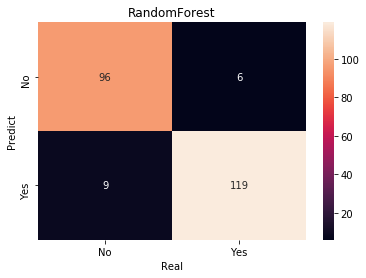

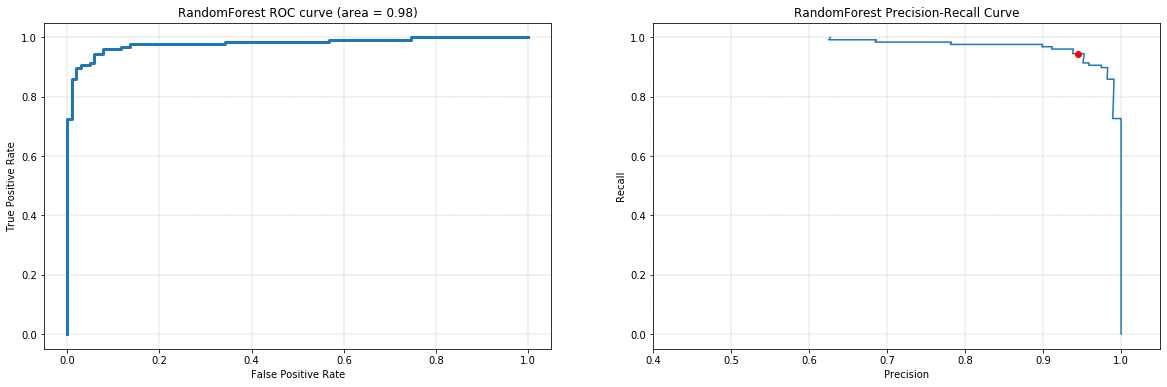

In [28]:
ts = 0.333
rf = model_training(RandomForestClassifier(random_state=42, 
                                           n_jobs=4, 
                                           n_estimators=50, 
                                           max_depth=max_depth,
                                           max_features=max_features),data_set, ts)

t=data_set.drop(columns=['Approved'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                     data_set['Approved'],
                                                     test_size=.333,
                                                     stratify=data_set['Approved'])

mod_eval(data_set, rf.predict(X_test), rf.predict_proba(X_test), y_test, 'RandomForest')
fi_df = pd.DataFrame({'fi': rf.feature_importances_},index=t.columns).sort_values(by='fi', ascending=False)
#X_train.to_csv('x_train_cc.csv')

In [29]:
X_train.head()

,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income
50,0,25.750000,0.5,1,0,1,3,0.875,1,0,0,1,0,134,0
380,1,43.170000,5.0,1,0,6,0,2.250,0,0,0,1,0,16,0
286,0,31.568171,1.5,1,0,5,2,0.000,0,1,2,1,0,40,105
350,0,26.170000,2.0,1,0,7,4,0.000,0,0,0,1,0,72,1
240,1,20.500000,10.0,2,2,1,7,2.500,1,0,0,0,2,110,0


## LogisticRegression

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       102
           1       0.90      0.77      0.83       128

    accuracy                           0.83       230
   macro avg       0.83      0.83      0.83       230
weighted avg       0.84      0.83      0.83       230



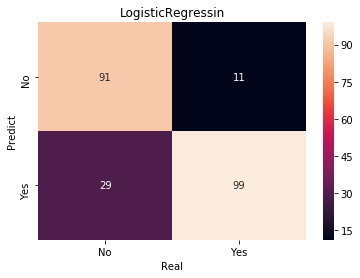

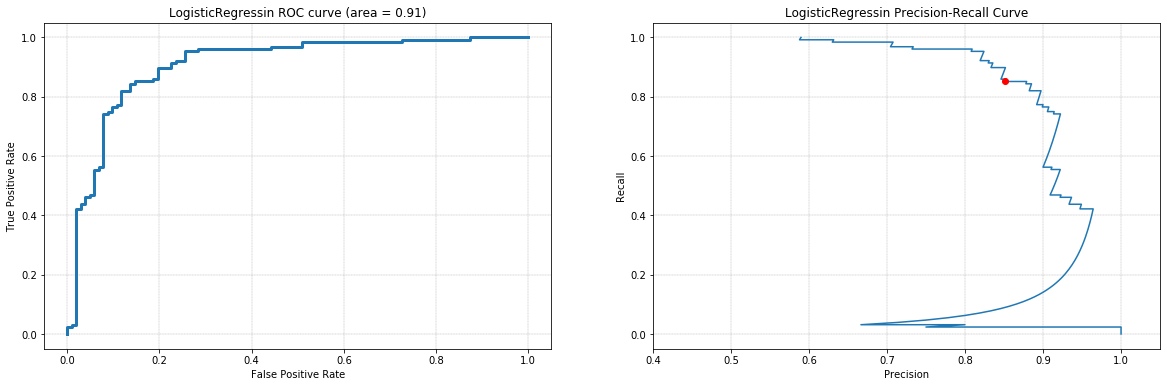

In [30]:
ts=0.333
lr = model_training(LogisticRegression(C=lr_C, 
                                       penalty=penalty,
                                       solver='liblinear',
                                       max_iter=1000),data_set, ts)

t=data_set.drop(columns=['Approved'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Approved'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Approved'])

t = 0.71
predprob = lr.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]

#pred_y = lr.predict(X_test)
mod_eval(data_set, pred_y, lr.predict_proba(X_test), y_test, 'LogisticRegressin') 
plt.show()

## NaiveBayes

              precision    recall  f1-score   support

           0       0.82      0.66      0.73       102
           1       0.76      0.88      0.82       128

    accuracy                           0.78       230
   macro avg       0.79      0.77      0.77       230
weighted avg       0.79      0.78      0.78       230



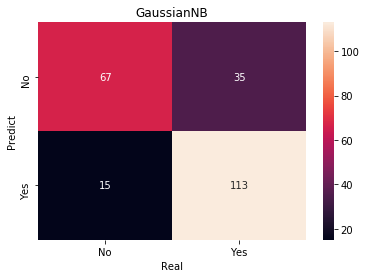

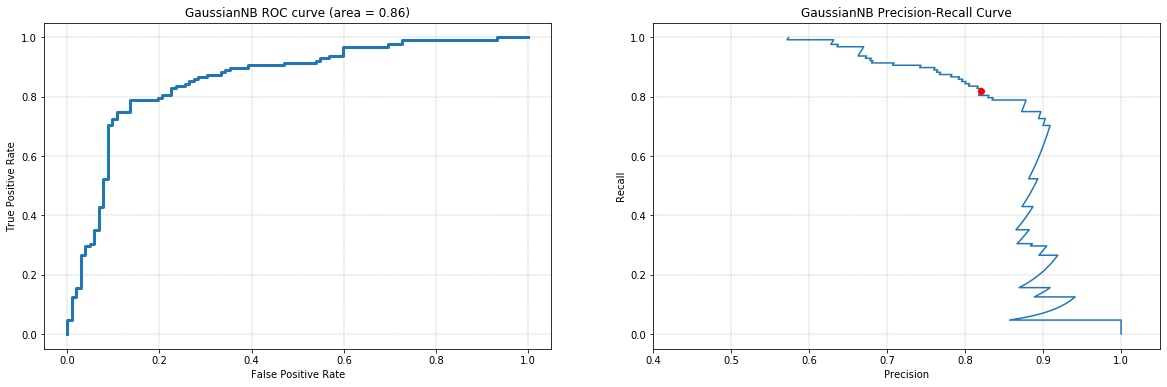

In [31]:
gnb = model_training(GaussianNB(),data_set, ts)

t=data_set.drop(columns=['Approved'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Approved'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Approved'])


t = 0.75
predprob = gnb.predict_proba(X_test)

pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]
#pred_y = gnb.predict(X_test)
mod_eval(data_set,pred_y, gnb.predict_proba(X_test), y_test, 'GaussianNB')
plt.show()

## SVC

In [32]:
svc = model_training(SVC(kernel='linear',
                         C=1, 
                         gamma='auto',
                         class_weight='balanced',
                         probability=True),data_set, ts)
t=data_set.drop(columns=['Approved'])
X_train, X_test, y_train, y_test = train_test_split(t,
                                                    data_set['Approved'],
                                                    test_size=ts,
                                                    random_state = 42, stratify=data_set['Approved'])

t=0.75
predprob = svc.predict_proba(X_test)
pred_y = [np.ceil(x) if x>=t else np.floor(x) for x in predprob[:,1]]

In [33]:
#export preTrained models

from joblib import dump, load


dump(svc, 'svc_cc.joblib')
dump(rf, 'rf_cc.joblib')
dump(gnb, 'gnb_cc.joblib')
dump(lr, 'lr_cc.joblib')

['svc_cc.joblib']

['rf_cc.joblib']

['gnb_cc.joblib']

['lr_cc.joblib']

In [ ]:
import aif360

In [11]:
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset
from IPython.display import Markdown, display

In [ ]:
#quick demonstration of disparate impact using a built in dataset

dataset_orig = GermanDataset(
    protected_attribute_names=['age'],           # this dataset also contains protected
                                                 # attribute for "sex" which we do not
                                                 # consider in this evaluation
    privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)

#dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

In [12]:
#back to the initial loan application dataset

data_set.head()

,Gender,Education,Self_Employed,Credit_History,Loan_Status,Property_Area_Semiurban,Property_Area_Urban,ln_monthly_return,ln_total_income,ln_LoanAmount
Loan_ID,,,,,,,,,,
LP001003,1,1,0,1.0,1,0,0,-3.084347,1.817078,0.158749
LP001005,1,1,1,1.0,1,0,1,-28.870091,-27.109971,-28.307318
LP001006,1,0,0,1.0,1,0,1,-5.596780,-6.729698,-2.614841
LP001008,1,1,0,1.0,1,0,1,0.681259,1.202233,4.315774
LP001011,1,1,1,1.0,1,0,1,25.537110,20.455218,31.755291


In [13]:
#code from: https://www.ambiata.com/blog/2019-12-13-bias-detection-and-mitigation/

def get_disparity_index(di):
    return 1 - np.minimum(di, 1 / di)

df_aif = BinaryLabelDataset(df=data_set, label_names=['Loan_Status'], protected_attribute_names=['Gender'])

privileged_group = [{'Gender': 1}] #male=1
unprivileged_group = [{'Gender': 0}] #female=0

In [14]:
metric_orig = BinaryLabelDatasetMetric(df_aif, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig.disparate_impact()).round(3))

1-min(DI, 1/DI): 0.466


This is the probability of success given the jobseeker is unprivileged (female), divided by the probability of success given the jobseeker is privileged (male). We further recast this as 1 - min(DI, 1/DI), since DI can be greater than 1, which would mean that the privileged group is disadvantaged. For our fairness benchmark, we require that 1 - min(DI, 1/DI) < 0.2

In [15]:
if get_disparity_index(metric_orig.disparate_impact()).round(3) < 0.2:
    print('The original data can be considered to be not biased')
else:
    print('There is a potential bias')

There is a potential bias


Now let's check the predicted results of the previously defined test data to see if the model output was biased when feeding it test data

In [ ]:
df = pd.DataFrame(pred_y, columns=['Pred'])
pred_test = pd.concat([X_test.reset_index(drop='True'),df.reset_index(drop='True')],axis=1)

In [ ]:
df_aif = BinaryLabelDataset(df=pred_test, label_names=['Pred'], protected_attribute_names=['Gender'])

metric_orig = BinaryLabelDatasetMetric(df_aif, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig.disparate_impact()).round(3))

In [ ]:
if get_disparity_index(metric_orig.disparate_impact()).round(3) < 0.2:
    print('The outcome of the test data can be considered to be not biased')
else:
    print('There is a potential bias')

As a next step, random data is generated to see if the pre-trained model shows a bias on completely unbiased data

In [ ]:
X_test.dtypes

In [ ]:
X_test.describe()

In [ ]:
X_test.columns

In [ ]:
def is_binary(series, allow_na=False):
    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]

X_new = pd.DataFrame(columns=[])

for c in X_test.columns:
    if is_binary(X_test[c]):
        X_new[c] = np.random.binomial(1, .5, 1000)
    else:
        X_new[c] = np.random.normal(X_test[c].describe()[1], X_test[c].describe()[2], 1000)

In [ ]:
X_new.head()

Predicting the loan application outcome with the normally distributed data

In [ ]:
pred_y_n = svc.predict(X_new)

In [ ]:
df_n = pd.DataFrame(pred_y_n, columns=['Pred'])
pred_n = pd.concat([X_new.reset_index(drop='True'),df_n.reset_index(drop='True')],axis=1)

In [ ]:
df_aif = BinaryLabelDataset(df=pred_n, label_names=['Pred'], protected_attribute_names=['Gender'])

metric_orig = BinaryLabelDatasetMetric(df_aif, unprivileged_group, privileged_group)
print('1-min(DI, 1/DI):', get_disparity_index(metric_orig.disparate_impact()).round(3))

In [ ]:
if get_disparity_index(metric_orig.disparate_impact()).round(3) < 0.2:
    print('The outcome of the test data can be considered to be not biased')
else:
    print('There is a potential bias')